In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib


%load_ext autoreload
%autoreload 2

In [2]:
import simulation
import controller
from simulation import *
from main_bus import MainBus

Using TensorFlow backend.


### Initialization

In [3]:
whole_day = 1440

# Parameters

replay_length = 100000
iterations = 144 # num of ticks before training
epochs = 1000 # num of times network is unfrozen, trained
batch_size = 32 # num of samples from replay memory to train on
animate = False
add_arrivals_noise = False

# Model
loggers = []
simulation = Simulation(MainBus, loggers=loggers)
replay_memory = deque(maxlen = replay_length)
training_results = []
training_loss = []
delivered_passeners = []

save_every = 10

Initializing Prob Dist


### Training

In [4]:
# Main training loop

for epoch in range(epochs):
    print('Epoch #%d' % (epoch+1))
    day_time = 0
    simulation.reset(add_arrivals_noise) # resets everything
    
    while day_time < whole_day:
        training_results.append(simulation.execute(iterations=iterations)) # simulate and collect logs
        

        replay_memory.extend(simulation.controller.replay_memory) # store data into replay memory

        if len(replay_memory)  > batch_size:
            # Get random samples
            training_idx = np.random.choice(len(replay_memory), size = batch_size)
            training_samples = [replay_memory[i] for i in training_idx]

            # Train DQN
            simulation.controller.destination_model.train(training_samples)
        
        day_time += iterations
        
    training_loss.append(simulation.controller.get_total_cost()) # collect loss
    delivered_passeners.append(simulation.controller.num_passengers_delivered)
    print('\r\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))
    
    if epoch % save_every == 0:
        simulation.controller.save_destination_model('decision_model')
        print('### CHECKPOINT ###')

Epoch #1
 101 / 1440 

C:\Users\Dana\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1960: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


	delivered:826
### CHECKPOINT ###
Epoch #2
	delivered:657
Epoch #3
	delivered:751
Epoch #4
	delivered:846
Epoch #5
	delivered:474
Epoch #6
	delivered:253
Epoch #7
	delivered:428
Epoch #8
	delivered:237
Epoch #9
	delivered:409
Epoch #10
	delivered:553
Epoch #11
	delivered:488
### CHECKPOINT ###
Epoch #12
	delivered:532
Epoch #13
	delivered:646
Epoch #14
	delivered:410
Epoch #15
	delivered:319
Epoch #16
	delivered:430
Epoch #17
	delivered:545
Epoch #18
	delivered:380
Epoch #19
	delivered:526
Epoch #20
	delivered:342
Epoch #21
	delivered:681
### CHECKPOINT ###
Epoch #22
	delivered:546
Epoch #23
	delivered:463
Epoch #24
	delivered:482
Epoch #25
	delivered:239
Epoch #26
	delivered:305
Epoch #27
	delivered:522
Epoch #28
	delivered:470
Epoch #29
	delivered:330
Epoch #30
	delivered:279
Epoch #31
	delivered:537
### CHECKPOINT ###
Epoch #32
	delivered:354
Epoch #33
	delivered:244
Epoch #34
	delivered:324
Epoch #35
	delivered:454
Epoch #36
	delivered:610
Epoch #37
	delivered:419
Epoch #38
	delive

KeyboardInterrupt: 

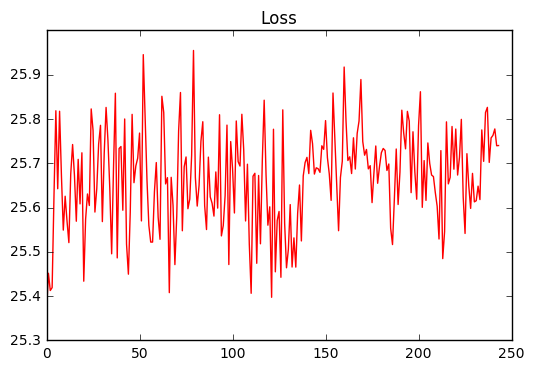

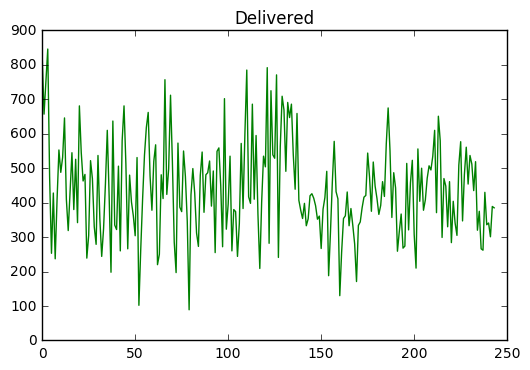

In [5]:
plt.plot(training_loss, 'r-')
plt.title('Loss')
plt.show()

plt.plot(delivered_passeners, 'g-')
plt.title('Delivered')
plt.show()

In [6]:
simulation.reset()
simulation.execute(iterations=700, animate=True)

{}

In [7]:
HTML(simulation.anim.to_html5_video())